In [115]:
import numpy as np
from numpy.random import seed
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from uuid import uuid4
import json
import os
from tqdm import tqdm
import subprocess
#for reproducibility
seed(1)

__TODO__ 
- for presentation, see if we can reduce the size of simulated data
- assistments datasets
- learner ability over time (probably need synthetic for this)
- look at the item information curves
- do simulations that show how a test with lower discrimination items needs more items to produce a classifier with the same accuracy
- goodness of fit
- standard error of measurment (ETS paper)

In [276]:
N_ITEMS = 2000
N_SUBJECTS = 10_000

In [164]:
def generate_subject_responses(subject):

    item_responses = items.apply(lambda item: {item["id"]: np.random.binomial(n=1,p=irf(diff=item["difficulty"],disc=item["discrimination"],ability=subject["ability"]))},axis=1).tolist()
    item_responses = {"subject_id": subject["id"], 
                      "responses": {k:v for item in item_responses for k,v in item.items()}}
    return item_responses

In [182]:
def exp_part(diff: float, disc: float, ability: float):
    return np.exp(-disc*(ability-diff))

In [185]:
def irf(diff: float, disc: float, ability: float):
    """Item Response (Characteristic) Function
    
    Compute the probability that a subject with given ability will answer an item 
    with difficulty `diff` and discrimination `disc` correctly
    
    """
    return 1/(1 + exp_part(diff,disc,ability))
    #return 1/(1+ np.exp(-disc*(ability-diff)))

In [189]:
def iic(diff, disc, ability):
    """The item information curve is the first derivative of the IRF"""
    return disc*exp_part(diff,disc,ability)/(1 + exp_part(diff,disc,ability)**2)

In [166]:
def read_jsonlines_from_disk(path: str) -> list:
    lines = list()
    with open(path, "rb") as f:
        for line in f.readlines():   
            l = json.loads(line)
            lines.append(l)
    return lines

In [167]:
def write_to_jsonlines(lst: list, filename: str):
    with open(filename,"w") as f:
        for line in lst:
            f.write(json.dumps(line))
            f.write(f"\n")
        

In [168]:
def get_fitted_abilities(location: str) -> pd.DataFrame:
    with open(os.path.join(location,"best_parameters.json"), "rb") as f:
        params = json.load(f)
        abilities = pd.DataFrame({"subject_id": params["subject_ids"].values(), "ability": params["ability"]})
        return abilities

In [169]:
def get_subject_predictions(subject_responses: dict, fitted_item_params:pd.DataFrame, fitted_abilities) -> float:
    """Compute the prediction accuracy for one student

    Args: 
        subject_responses is a dict with the following schema
        {'subject_id': '0d73c50b-ad47-4c8f-8e6a-18d4e817358d',
         'responses': {'3a485c21-6079-437d-a580-3bc6f36187e2': 0,
         ....
         }
        item_params is a dataframe with columns item_id, discrimination, difficulty
        
    """
    
    #retrieve the 'true' responses
    y_true_pred= pd.DataFrame({"item_id":subject_responses["responses"].keys(), "correct": subject_responses["responses"].values()})
    #extract the ability for this subject
    theta = fitted_abilities[fitted_abilities["subject_id"] ==subject_responses["subject_id"]]["ability"].iloc[0]
    #use the item response function to predict a probability that the subject will answer the question correctly, 
    #then round the probability to get a 1 or 0 prediction
    y_true_pred["pred"]= irf(ability=theta, diff=fitted_item_params["difficulty"], disc=fitted_item_params["discrimination"]).round().astype(int)
    return y_true_pred

In [170]:
def get_acc(y_true_pred):
    #return the proportion of correct predictions
    return len(y_true_pred[y_true_pred["correct"] == y_true_pred["pred"]])/len(y_true_pred)

In [171]:
def get_fitted_item_params(location: str) -> pd.DataFrame:
    with open(os.path.join(location,"best_parameters.json"), "rb") as f:
        params = json.load(f)
        item_params = pd.DataFrame({"item_id": params["item_ids"].values(), "difficulty": params["diff"], "discrimination": params["disc"]})
        return item_params

In [172]:
def get_item_responses(subject_responses: list, item_id: str):
    """Get all the responses for one item"""
    responses = dict()
    for subject in subject_responses:
        response = subject["responses"][item_id]
        responses[subject["subject_id"]] = response
    responses = pd.DataFrame({"subject_id": responses.keys(), "correct": responses.values()})
    responses["item_id"] = item_id
    return responses

In [173]:
def get_item_predictions(fitted_abilities: pd.DataFrame, item_params: pd.DataFrame, item_id: str):
    """Get all the predicitons for one item"""
    
    difficulty = item_params[item_params.item_id == item_id]["difficulty"].iloc[0]
    discrimination = item_params[item_params.item_id == item_id]["discrimination"].iloc[0]
    #fixme probably want to return subject ids with preds
    probabilities = fitted_abilities.ability.apply(lambda ability: irf(ability=ability, diff=difficulty, disc=discrimination))
    predictions = pd.DataFrame({"subject_id": fitted_abilities["subject_id"], "prediction": probabilities.round().astype(int)})
    predictions["item_id"] =item_id
    return predictions
                                   
        
    
    

    

In [176]:
def get_y_true_pred(subject_responses, fitted_item_params, fitted_abilities):
    y_true_pred = list()
    for item_id in tqdm(fitted_item_params.item_id, "item"):
        this_item_responses = get_item_responses(item_id=item_id,subject_responses=subject_responses)
        this_item_preds = get_item_predictions(item_id=item_id, fitted_abilities=fitted_abilities, item_params=fitted_item_params)
        this_item_responses["subject_id"] = this_item_responses["subject_id"].astype(str)
        y_true_pred.append(this_item_preds.merge(this_item_responses, on=["subject_id","item_id"]).rename(columns={"prediction":"pred"}))
    
    y_true_pred = pd.concat(y_true_pred)
    return y_true_pred
        

In [174]:
def construct_lsat7_dataset(path_to_csv: str = "/home/daavid/lsat7.csv") -> pd.DataFrame:
    lsat7 = pd.read_csv(path_to_csv)
    lsat7 = lsat7.drop(columns="Unnamed: 0")
    lsat7 = lsat7.rename(columns={col:col.replace(".","_") for col in lsat7.columns})
    lsat7.index.repeat(lsat7.freq)
    expanded = pd.DataFrame(np.repeat(lsat7.values, lsat7.freq, axis=0),columns=lsat7.columns).drop(columns="freq")
    return expanded
    

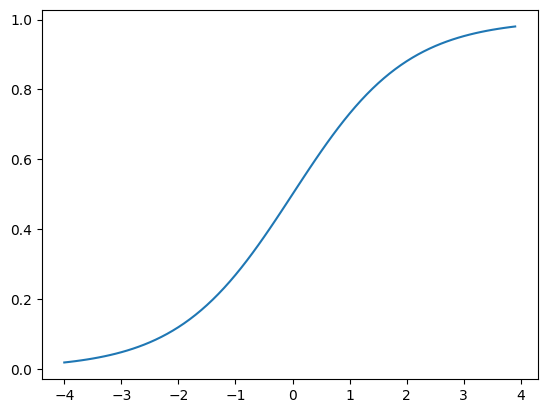

In [186]:
x = np.arange(-4,4,0.1)
y =irf(diff=0,disc=1,ability=x)
plt.plot(x,y)

__Item Information Curve__

Text(0.5, 1.0, 'Item Information Curve')

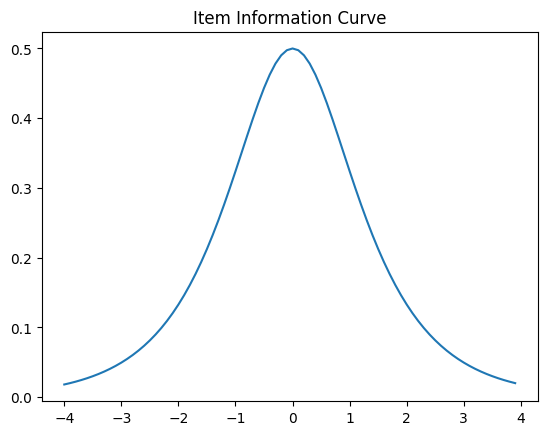

In [191]:
x = np.arange(-4,4,0.1)
y =iic(diff=0,disc=1,ability=x)
plt.plot(x,y)
plt.title("Item Information Curve")
plt.xlabel("Theta")
plt.ylabel("

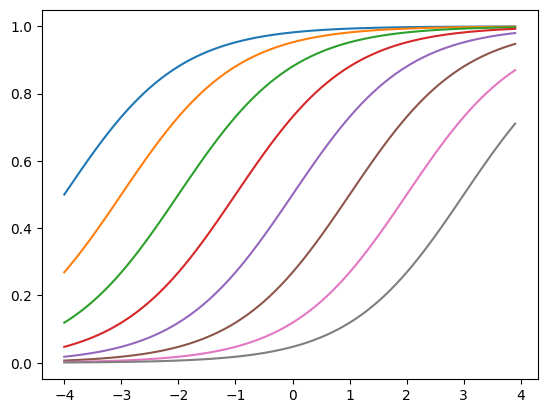

In [198]:
x = np.arange(-4,4,0.1)
for diff in np.arange(-4,4,1):
    y =irf(diff=diff,disc=1,ability=x)
    plt.plot(x,y)

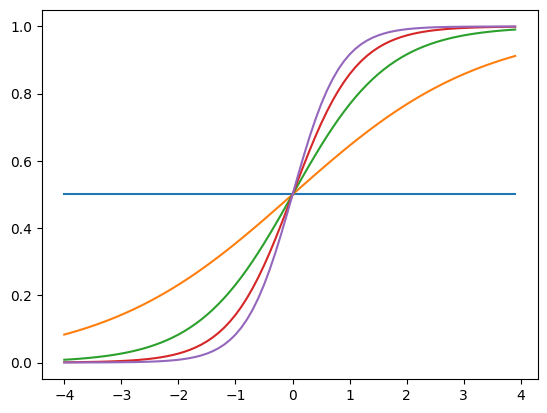

In [207]:
x = np.arange(-4,4,0.1)
for disc in np.arange(0,3,0.6):
    y =irf(diff=0,disc=disc,ability=x)
    plt.plot(x,y)

generate some synthetic data

(array([  31.,  199.,  768., 1851., 2683., 2418., 1446.,  477.,  112.,
          15.]),
 array([-3.41019123, -2.70110886, -1.9920265 , -1.28294413, -0.57386176,
         0.13522061,  0.84430298,  1.55338535,  2.26246772,  2.97155009,
         3.68063246]),
 <BarContainer object of 10 artists>)

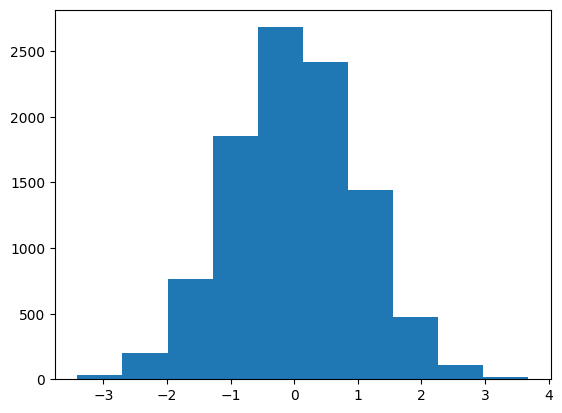

In [208]:
abilities = np.random.normal(size=N_SUBJECTS,loc=0,scale=1.01)
difficulties =   np.random.normal(size=N_ITEMS,loc=0,scale=1.01)
discriminations = np.random.normal(size=N_ITEMS,loc=0,scale=1.01)

plt.hist(abilities)

In [24]:
#generate abilities
#generate questions (ie, diff and disc)
#using the diff, disc, and abilities, you know what the probabilities are that any particular student would answer that question correctly.
#so use that to generate responses for each student and each question

In [210]:
subjects = pd.DataFrame({"id": [str(uuid4()) for i in range(N_SUBJECTS) ], "ability": abilities})
items = pd.DataFrame({"id": [str(uuid4()) for i in range(N_ITEMS)], "difficulty": difficulties, "discrimination": discriminations })

In [39]:
subjects

,id,ability
0,21efc818-50df-4ac4-a611-b2f8955c3b2c,1.640589
1,763a0373-5992-43e5-b474-727f2598dc46,-0.617874
2,29b738a3-b72a-4bba-9c26-c55b61b59410,-0.533453
3,14b3cd59-bc3c-4aba-b22a-3ac3143b4885,-1.083698
4,f3fba37b-d874-4fc9-aabe-d18d643d1295,0.874062
...,...,...
9995,6d5543f8-e5cd-4b41-bace-7a7d2298dd23,0.073688
9996,7829c7c5-1c46-4aa2-bbdb-24963ac3a003,0.493993
9997,6ef88c5c-2eeb-4f19-b5cc-beda7e7eaf55,-1.024285
9998,1135e886-a079-4f20-9092-f0911ef42219,-0.063323


In [211]:
items

,id,difficulty,discrimination
0,3a485c21-6079-437d-a580-3bc6f36187e2,-1.741165,-0.365329
1,99aadb46-c383-4dac-848c-b0b2ed55e3ff,0.034001,0.605162
2,127f19ce-1297-4399-840d-6671a308273d,0.549769,-0.000411
3,e7efaa55-e7a3-4631-b7e2-fd5c960bfc66,-2.060970,0.246602
4,c5744e8f-e36b-4a4d-a964-d2f3d7e0e296,0.974870,0.885402
...,...,...,...
1995,3968e0ae-f407-4ef6-b23b-c70a56a02c3f,-0.343013,1.565251
1996,7129dadb-95af-4b27-a6f6-39cd41ac9bc8,-1.146596,-0.741433
1997,9e5c71bb-4d0e-4936-8845-60290be63e8e,1.912802,0.185735
1998,d06cb767-5cb2-4958-af5b-22d5f0004885,-0.470551,0.178558


## Generate responses

In [49]:
[{"subject_id": subject_id, **{item_id: np.random.binomial(n=1,p=irf(diff=difficulties,disc=discriminations,ability=0))

array([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0])

In [59]:
items

,id,difficulty,discrimination
0,82938f30-c85d-4d1f-8045-8c40377e1d36,-0.123699,-1.475666
1,06a8ac90-bcd7-444b-b27d-f672ca817546,0.230452,1.489526
2,daa1afca-7b75-457c-9a9c-392453bc9150,-0.355828,1.215772
3,fab9cd87-6dce-41f2-9e13-f691bb57e786,-0.838859,0.739943
4,60dc652e-8640-4e3e-bfe2-8ce15fdedbb3,-0.263701,0.852650
...,...,...,...
95,da78ab2e-5202-437a-8a3f-c33ea0f01ce0,-0.402485,-1.117401
96,51bf181d-e2f4-413d-b1e0-d869a2d9edf9,0.368278,1.505461
97,e9958f56-a4ec-4196-acfa-2bb37d33b927,-0.158742,0.124914
98,3c2e0ecf-958d-4df2-8cbc-c1740807936c,0.544037,-1.799727


In [213]:
subject_responses = subjects.apply(generate_subject_responses,axis=1)

In [214]:
#make jsonlines
subject_responses = subject_responses.tolist()

In [215]:
write_to_jsonlines(subject_responses, "synthetic_subjects.jsonl")

In [ ]:
!py-irt train 2pl synthetic_subjects.jsonl 2pl-params/  --epochs 1000 --deterministic
#!py-irt train 2pl synthetic_subjects.jsonl 2pl-params/  --epochs 2000 --deterministic


[17:21:43] config: model_type='2pl' epochs=1000 priors=None           ]8;id=1699395703.5026793-288819;file:///home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/py_irt/cli.py\cli.py]8;;\:109
           initializers=[] dims=None lr=0.1 lr_decay=0.9999                     
           dropout=0.5 hidden=100 vocab_size=None log_every=100                 
           seed=None deterministic=True                                         
           data_path: synthetic_subjects.jsonl                        ]8;id=1699395703.5038514-149982;file:///home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/py_irt/cli.py\cli.py]8;;\:111
           output directory: 2pl-params/                              ]8;id=1699395703.5047572-306428;file:///home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/py_irt/cli.py\cli.py]8;;\:112
[17:21:52] amortized: False                                       ]8;id=1699395712.560957-157206;file:///home/daavid/PycharmProje

In [287]:
fitted_abilities = get_fitted_abilities("2pl-params")

In [236]:
true_pred_abilities = fitted_abilities.merge(subjects, left_on="subject_id", right_on="id", suffixes=("_pred","_true"))

<Axes: >

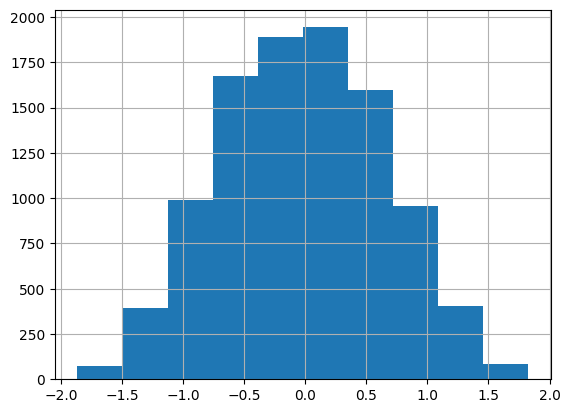

In [238]:
true_pred_abilities["ability_pred"].hist()

<Axes: >

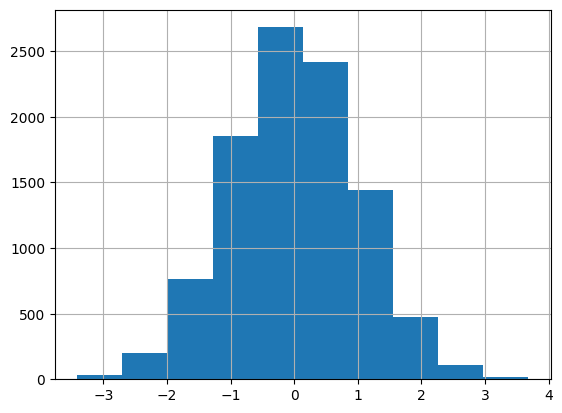

In [239]:
true_pred_abilities["ability_true"].hist()

- Do a train/test split
- get some real data - apparently there is an LSAT test out there

In [246]:
fitted_item_params = get_fitted_item_params("2pl-params")

In [247]:
fitted_item_params

,item_id,difficulty,discrimination
0,3a485c21-6079-437d-a580-3bc6f36187e2,0.904554,0.572481
1,99aadb46-c383-4dac-848c-b0b2ed55e3ff,0.024610,0.033441
2,127f19ce-1297-4399-840d-6671a308273d,0.138231,0.091528
3,e7efaa55-e7a3-4631-b7e2-fd5c960bfc66,-1.258883,0.191092
4,c5744e8f-e36b-4a4d-a964-d2f3d7e0e296,1.770364,0.226426
...,...,...,...
1995,3968e0ae-f407-4ef6-b23b-c70a56a02c3f,-0.364601,0.036057
1996,7129dadb-95af-4b27-a6f6-39cd41ac9bc8,0.752531,1.002718
1997,9e5c71bb-4d0e-4936-8845-60290be63e8e,0.718509,0.131854
1998,d06cb767-5cb2-4958-af5b-22d5f0004885,-0.056838,0.065889


<Axes: >

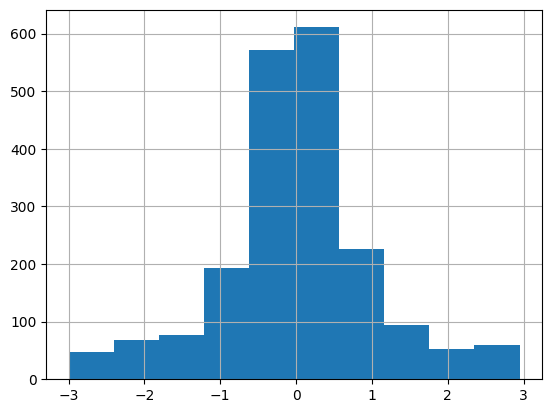

In [356]:
fitted_item_params["difficulty"].hist()

<Axes: >

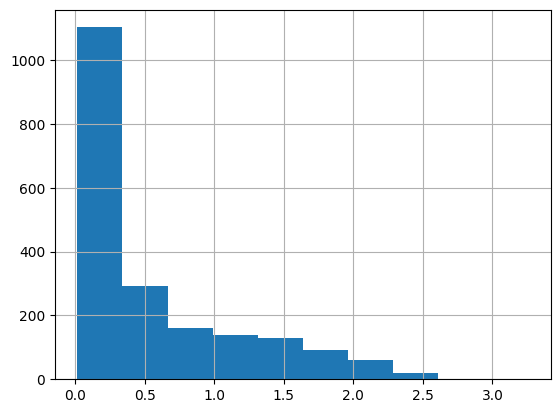

In [357]:
fitted_item_params["discrimination"].hist()

compute training accuracy/auc

- We can compute student-level accuracy
- We can compute question-level accuracy
- We can compute overall accuracy

In [288]:
fitted_abilities

,subject_id,ability
0,0d73c50b-ad47-4c8f-8e6a-18d4e817358d,0.520831
1,7fd5e499-8093-40de-89b0-35902d5cf884,0.151939
2,1393949f-75f2-4cf0-977e-9b09f27f693b,-0.059761
3,5dccd482-33a1-4079-b910-ab702033c2b4,-0.564737
4,ec40eefe-1f17-4bcc-aaa4-b770af4c4aad,0.355001
...,...,...
9995,46ca74a1-6d9a-49fa-a68f-93eab40ccbf4,1.164813
9996,920cd17b-6d88-46e0-9301-345a8cf19f77,0.546812
9997,b8a31d17-1476-418d-ac20-a50b74b8a591,0.088482
9998,3963b30e-cd8f-436d-a5b1-7f3a3a560cc9,-0.754518


#### Compute the subject-level accuracy for all subjects

In [307]:
subj_acc = dict()
for subject in subject_responses:
    subject_preds = get_subject_predictions(subject_responses=subject, fitted_item_params=fitted_item_params,fitted_abilities=fitted_abilities)
    subj_acc[subject["subject_id"]] = get_acc(subject_preds)
subj_acc_df = pd.DataFrame({"subject_id": subj_acc.keys(),"accuracy":subj_acc.values()})
subj_acc_df
    

,subject_id,accuracy
0,0d73c50b-ad47-4c8f-8e6a-18d4e817358d,0.5905
1,7fd5e499-8093-40de-89b0-35902d5cf884,0.6190
2,1393949f-75f2-4cf0-977e-9b09f27f693b,0.6315
3,5dccd482-33a1-4079-b910-ab702033c2b4,0.6045
4,ec40eefe-1f17-4bcc-aaa4-b770af4c4aad,0.6055
...,...,...
9995,46ca74a1-6d9a-49fa-a68f-93eab40ccbf4,0.5570
9996,920cd17b-6d88-46e0-9301-345a8cf19f77,0.6045
9997,b8a31d17-1476-418d-ac20-a50b74b8a591,0.6455
9998,3963b30e-cd8f-436d-a5b1-7f3a3a560cc9,0.5880


#### Compute the  mean subject-level accuracy

In [308]:
subj_acc_df.accuracy.mean()

0.60277895

#### Compute the question-level accuracy for all quesitons

In [311]:
subject_responses[0]["responses"]["3a485c21-6079-437d-a580-3bc6f36187e2"]

0

In [343]:
responses = get_item_responses(subject_responses,"3a485c21-6079-437d-a580-3bc6f36187e2")
responses

,subject_id,correct,item_id
0,0d73c50b-ad47-4c8f-8e6a-18d4e817358d,0,3a485c21-6079-437d-a580-3bc6f36187e2
1,7fd5e499-8093-40de-89b0-35902d5cf884,1,3a485c21-6079-437d-a580-3bc6f36187e2
2,1393949f-75f2-4cf0-977e-9b09f27f693b,0,3a485c21-6079-437d-a580-3bc6f36187e2
3,5dccd482-33a1-4079-b910-ab702033c2b4,0,3a485c21-6079-437d-a580-3bc6f36187e2
4,ec40eefe-1f17-4bcc-aaa4-b770af4c4aad,0,3a485c21-6079-437d-a580-3bc6f36187e2
...,...,...,...
9995,46ca74a1-6d9a-49fa-a68f-93eab40ccbf4,1,3a485c21-6079-437d-a580-3bc6f36187e2
9996,920cd17b-6d88-46e0-9301-345a8cf19f77,0,3a485c21-6079-437d-a580-3bc6f36187e2
9997,b8a31d17-1476-418d-ac20-a50b74b8a591,0,3a485c21-6079-437d-a580-3bc6f36187e2
9998,3963b30e-cd8f-436d-a5b1-7f3a3a560cc9,0,3a485c21-6079-437d-a580-3bc6f36187e2


In [344]:
predictions = get_item_predictions(fitted_abilities=fitted_abilities, item_params = fitted_item_params, item_id  = "3a485c21-6079-437d-a580-3bc6f36187e2")
predictions

,subject_id,prediction,item_id
0,0d73c50b-ad47-4c8f-8e6a-18d4e817358d,0,3a485c21-6079-437d-a580-3bc6f36187e2
1,7fd5e499-8093-40de-89b0-35902d5cf884,0,3a485c21-6079-437d-a580-3bc6f36187e2
2,1393949f-75f2-4cf0-977e-9b09f27f693b,0,3a485c21-6079-437d-a580-3bc6f36187e2
3,5dccd482-33a1-4079-b910-ab702033c2b4,0,3a485c21-6079-437d-a580-3bc6f36187e2
4,ec40eefe-1f17-4bcc-aaa4-b770af4c4aad,0,3a485c21-6079-437d-a580-3bc6f36187e2
...,...,...,...
9995,46ca74a1-6d9a-49fa-a68f-93eab40ccbf4,1,3a485c21-6079-437d-a580-3bc6f36187e2
9996,920cd17b-6d88-46e0-9301-345a8cf19f77,0,3a485c21-6079-437d-a580-3bc6f36187e2
9997,b8a31d17-1476-418d-ac20-a50b74b8a591,0,3a485c21-6079-437d-a580-3bc6f36187e2
9998,3963b30e-cd8f-436d-a5b1-7f3a3a560cc9,0,3a485c21-6079-437d-a580-3bc6f36187e2


The way we've written `get_item_reponses` and `get_item_predictions` allows us to not only get the item-level accuracies, but compute overall accuracy by concatting all the predictions and responses together in one table and calculating the accuracy

In [352]:
y_true_pred = list()
for item_id in tqdm(fitted_item_params.item_id, "item"):
    this_item_responses = get_item_responses(item_id=item_id,subject_responses=subject_responses)
    this_item_preds = get_item_predictions(item_id=item_id, fitted_abilities=fitted_abilities, item_params=fitted_item_params)
    y_true_pred.append(this_item_preds.merge(this_item_responses).rename(columns={"prediction":"pred"}))

y_true_pred = pd.concat(y_true_pred)
    

item: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:14<00:00, 26.74it/s]


In [353]:
y_true_pred

,subject_id,pred,item_id,correct
0,0d73c50b-ad47-4c8f-8e6a-18d4e817358d,0,3a485c21-6079-437d-a580-3bc6f36187e2,0
1,7fd5e499-8093-40de-89b0-35902d5cf884,0,3a485c21-6079-437d-a580-3bc6f36187e2,1
2,1393949f-75f2-4cf0-977e-9b09f27f693b,0,3a485c21-6079-437d-a580-3bc6f36187e2,0
3,5dccd482-33a1-4079-b910-ab702033c2b4,0,3a485c21-6079-437d-a580-3bc6f36187e2,0
4,ec40eefe-1f17-4bcc-aaa4-b770af4c4aad,0,3a485c21-6079-437d-a580-3bc6f36187e2,0
...,...,...,...,...
9995,46ca74a1-6d9a-49fa-a68f-93eab40ccbf4,0,93fb9acf-ff48-4e3a-b2ba-b7c8304e3625,0
9996,920cd17b-6d88-46e0-9301-345a8cf19f77,0,93fb9acf-ff48-4e3a-b2ba-b7c8304e3625,0
9997,b8a31d17-1476-418d-ac20-a50b74b8a591,0,93fb9acf-ff48-4e3a-b2ba-b7c8304e3625,0
9998,3963b30e-cd8f-436d-a5b1-7f3a3a560cc9,0,93fb9acf-ff48-4e3a-b2ba-b7c8304e3625,0


In [354]:
get_acc(y_true_pred)

0.60277895

In [ ]:
#let's try simulating data that more closely match the assumptions of py-irt, namely that the discrimination is bigger than 0

In [358]:
discriminations = np.random.gamma(size=N_ITEMS, shape=1, scale=2)

(array([1.085e+03, 4.690e+02, 2.360e+02, 9.800e+01, 5.900e+01, 2.400e+01,
        1.900e+01, 6.000e+00, 3.000e+00, 1.000e+00]),
 array([1.93376662e-03, 1.48732445e+00, 2.97271513e+00, 4.45810582e+00,
        5.94349650e+00, 7.42888718e+00, 8.91427787e+00, 1.03996685e+01,
        1.18850592e+01, 1.33704499e+01, 1.48558406e+01]),
 <BarContainer object of 10 artists>)

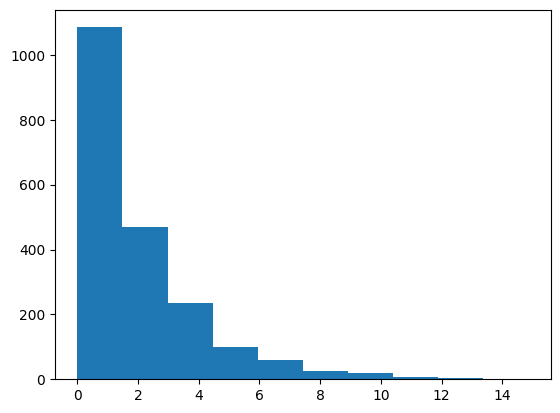

In [359]:
plt.hist(discriminations)

In [360]:
#subjects = pd.DataFrame({"id": [str(uuid4()) for i in range(N_SUBJECTS) ], "ability": abilities})
items = pd.DataFrame({"id": [str(uuid4()) for i in range(N_ITEMS)], "difficulty": difficulties, "discrimination": discriminations })

In [361]:
subject_responses = subjects.apply(generate_subject_responses,axis=1)

In [362]:
subject_responses = subject_responses.tolist()

In [363]:
write_to_jsonlines(subject_responses, "synthetic_subjects_gamma.jsonl")

In [ ]:
#!py-irt train 2pl synthetic_subjects_gamma.jsonl 2pl-params-gamma/  --epochs 1000 --seed 1

In [364]:
fitted_abilities = get_fitted_abilities("2pl-params-gamma")

In [365]:
true_pred_abilities = fitted_abilities.merge(subjects, left_on="subject_id", right_on="id", suffixes=("_pred","_true"))

<Axes: >

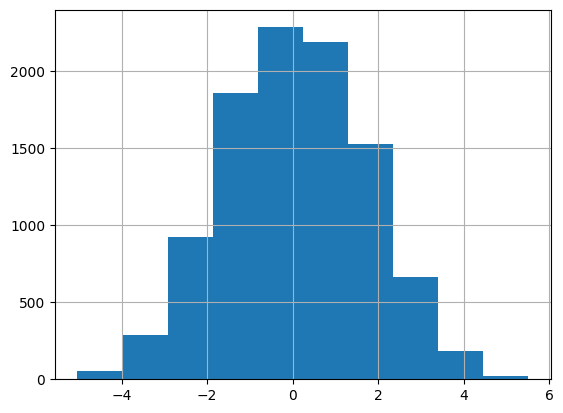

In [367]:
true_pred_abilities["ability_pred"].hist()

<Axes: >

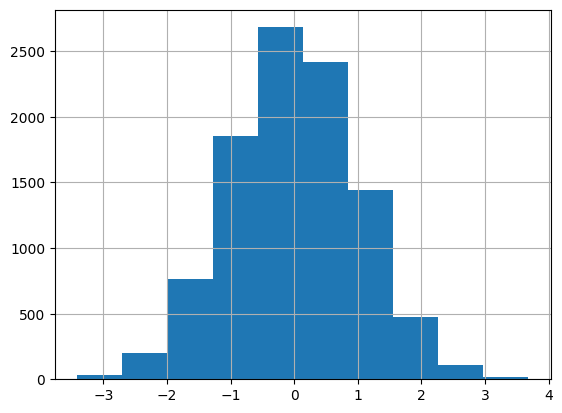

In [368]:
true_pred_abilities["ability_true"].hist()

In [369]:
fitted_item_params = get_fitted_item_params("2pl-params-gamma")

In [370]:
y_true_pred = list()
for item_id in tqdm(fitted_item_params.item_id, "item"):
    this_item_responses = get_item_responses(item_id=item_id,subject_responses=subject_responses)
    this_item_preds = get_item_predictions(item_id=item_id, fitted_abilities=fitted_abilities, item_params=fitted_item_params)
    y_true_pred.append(this_item_preds.merge(this_item_responses).rename(columns={"prediction":"pred"}))

y_true_pred = pd.concat(y_true_pred)
    

item: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:16<00:00, 26.05it/s]


In [371]:
get_acc(y_true_pred)

0.75039405

<Axes: >

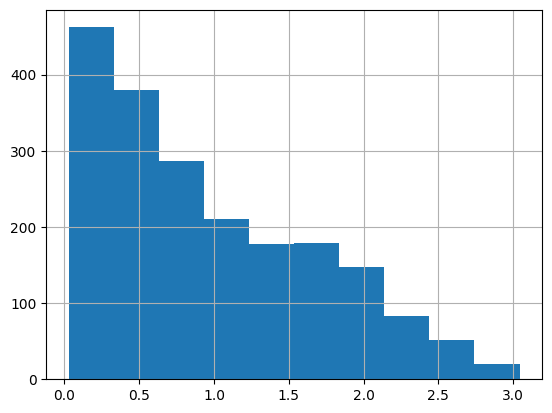

In [372]:
fitted_item_params["discrimination"].hist()

<Axes: >

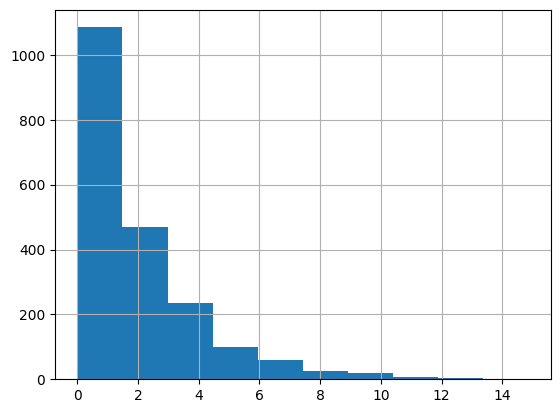

In [373]:
items["discrimination"].hist()

__TODO__ put this dataset on google drive or something

In [48]:
lsat7 = construct_lsat7_dataset()

In [404]:
lsat7.freq.sum()

1000

In [424]:
lsat_7_responses =  expanded.to_dict(orient="records")
lsat7_subjects = [{"subject_id": i, "responses":lsat_7_responses[i]} for i in range(1000)]

In [426]:
write_to_jsonlines(lsat7_subjects, "lsat7.jsonlines")

In [427]:
!py-irt train 2pl lsat7.jsonlines lsat7-params/  --epochs 2000 --seed 1


[16:33:33] config: model_type='2pl' epochs=2000 priors=None           ]8;id=1699911213.73236-596853;file:///home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/py_irt/cli.py\cli.py]8;;\:109
           initializers=[] dims=None lr=0.1 lr_decay=0.9999                     
           dropout=0.5 hidden=100 vocab_size=None log_every=100                 
           seed=1 deterministic=False                                           
           data_path: lsat7.jsonlines                                 ]8;id=1699911213.7334034-888598;file:///home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/py_irt/cli.py\cli.py]8;;\:111
           output directory: lsat7-params/                            ]8;id=1699911213.734273-841235;file:///home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/py_irt/cli.py\cli.py]8;;\:112
[16:33:33] amortized: False                                       ]8;id=1699911213.7404852-66172;file:///home/daavid/PycharmProjects

In [428]:
lsat_7_item_params = get_fitted_item_params("lsat7-params")

In [429]:
lsat_7_abilities = get_fitted_abilities("lsat7-params")

array([[<Axes: title={'center': 'ability'}>]], dtype=object)

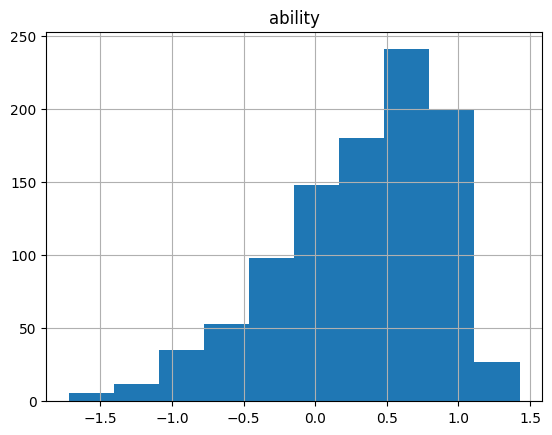

In [431]:
lsat_7_abilities.hist()

In [436]:
lsat_7_item_params

,item_id,difficulty,discrimination
0,Item_1,-0.899477,0.900605
1,Item_2,-0.319415,0.540296
2,Item_3,-0.752438,0.829449
3,Item_4,-0.190051,0.429757
4,Item_5,-0.961014,0.907258


<Axes: >

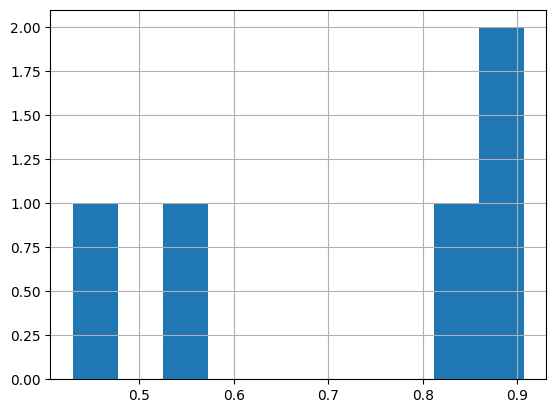

In [435]:
lsat_7_item_params.discrimination.hist()

In [455]:

lsat7_y_true_pred = get_y_true_pred(subject_responses=lsat7_subjects, fitted_item_params = lsat_7_item_params, fitted_abilities=lsat_7_abilities)

item: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.97it/s]


In [457]:
get_acc(lsat7_y_true_pred)

0.7858

__so the above is in-sample accuracy, we need to do a train-test split next__

In [1]:
!py-irt train-and-evaluate 2pl lsat7.jsonlines lsat7-train-test-split-params/  --epochs 2000 --seed 1


[09:14:55] config: model_type='2pl' epochs=2000 priors=None           ]8;id=1701180895.5470073-126073;file:///home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/py_irt/cli.py\cli.py]8;;\:176
           initializers=[] dims=None lr=0.1 lr_decay=0.9999                     
           dropout=0.5 hidden=100 vocab_size=None log_every=100                 
           seed=None deterministic=False                                        
           data_path: lsat7.jsonlines                                 ]8;id=1701180895.548602-879439;file:///home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/py_irt/cli.py\cli.py]8;;\:178
           output directory: lsat7-train-test-split-params/           ]8;id=1701180895.5496426-70232;file:///home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/py_irt/cli.py\cli.py]8;;\:179
[09:14:55] amortized: False                                       ]8;id=1701180895.5703044-509783;file:///home/daavid/PycharmProjec

In [21]:
predictions = read_jsonlines_from_disk(os.path.join("lsat7-train-test-split-params","model_predictions.jsonlines"))

In [42]:
y_true_pred = pd.DataFrame({"correct": [int(pred["response"]) for pred in predictions],"pred":  [round(pred["prediction"]) for pred in predictions] })

In [43]:
get_acc(y_true_pred)

0.76

__K-fold cross validation__

In [108]:
def k_splits(dataset: pd.DataFrame,k:int =5, seed=1):
    splits = list()
    dataset = dataset.sample(frac=1,random_state=seed)
    increment = int(len(dataset)/k)
    indices = [(n*increment, (n+1)*increment) for n in range(0,k)]   
    for start, end in indices:
        test = dataset[start:end]
        train = dataset.drop(test.index)
        splits.append((train,test))
    return splits
    
    
    

In [109]:
lsat_splits = k_splits(lsat7)

In [154]:
for k,(train,test) in enumerate(lsat_splits):
    split_path = os.path.join("lsat-kfold",f"split-{k+1}")
    if not os.path.exists(split_path):
        os.makedirs(split_path)
    train =  train.to_dict(orient="records")
    train_subjects = [{"subject_id": i, "responses":train[i]} for i in range(len(train))]
    write_to_jsonlines(train_subjects,os.path.join(split_path,"train.jsonlines"))
    #evaluate funcitonality is broken in py-irt
    #https://github.com/nd-ball/py-irt/issues/51
    # test_lines = list()
    # for subject_id, row in test.iterrows():
    #     for item, response in row.items():
    #         test_lines.append({"subject_id": subject_id, item: response})

    # write_to_jsonlines(test_lines,os.path.join(split_path,"test.jsonlines"))
    

__TODO__ declare dirs as constants at top of notebook, etc

In [158]:
K=5
for k in range(1,K+1):
    split_path = os.path.join("lsat-kfold", f"split-{k}")
    train_path = os.path.join(split_path, "train.jsonlines")
    test_path = os.path.join(split_path, "test.jsonlines")
    subprocess.run(f'py-irt train 2pl {train_path} {split_path} --epochs 2000 --seed 1'.split())
   #subprocess.run(f'py-irt evaluate 2pl  {split_path}/best_parameters.json {test_path} {split_path} --priors=vague'.split())

[13:53:38] config: model_type='2pl' epochs=2000 priors='vague'        cli.py:109
           initializers=[] dims=None lr=0.1 lr_decay=0.9999                     
           dropout=0.5 hidden=100 vocab_size=None log_every=100                 
           seed=1 deterministic=False                                           
           data_path: lsat-kfold/split-1/train.jsonlines              cli.py:111
           output directory: lsat-kfold/split-1                       cli.py:112
[13:53:38] amortized: False                                       dataset.py:112
[13:53:38] Vocab size: None                                       training.py:90
           Training Model...                                          cli.py:116
           args: {'device': 'cpu', 'num_items': 5,               training.py:134
           'num_subjects': 800}                                                 
           Parsed Model Args: {'device': 'cpu', 'num_items': 5,  training.py:147
           'num_subjects': 8

In [ ]:
#subprocess.run(f'py-irt evaluate 2pl  {split_path}/best_parameters.json {test_path} {split_path} --priors=vague'.split())

In [162]:
#!py-irt evaluate 2pl lsat-kfold/split-1/best_parameters.json lsat-kfold/split-1/test.jsonlines lsat-kfold/split-1/

In [180]:
split_accuracies = list()
for k,(train, test) in enumerate(lsat_splits):
    split_path = os.path.join(f"lsat-kfold/split-{k+1}")
    train =  train.to_dict(orient="records")
    train_subjects = [{"subject_id": i, "responses":train[i]} for i in range(len(train))]
    item_params = get_fitted_item_params(split_path)
    abilities = get_fitted_abilities(split_path)
    y_true_pred = get_y_true_pred(subject_responses=train_subjects, fitted_item_params = item_params, fitted_abilities=abilities)
    acc = get_acc(y_true_pred)
    split_accuracies.append(acc)
    
overall_acc = np.mean(split_accuracies)
overall_acc

item: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 102.81it/s]


0.78535